In [657]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import cv2
print(tf.__version__)


2.4.1


## Folders Setup

In [658]:
path = os.getcwd()
data = os.path.join(path,'data')

def folder_setup():
    """ works for linux only

    """
    df = pd.read_csv("train.csv")
    classes = df["label"].drop_duplicates().values.tolist()
    os.mkdir(os.path.join(path,'data'))
    
    # create classes folder
    for classe in classes :
        os.mkdir(os.path.join(path,'data',classe))

    # copy the image in the right classes folder
    for index, values in df.iterrows():
        os.system(f"cp {os.path.join(path,values[1])} {os.path.join(path,'data',values[2],values[1].split('/')[1])}")  

In [659]:
#folder_setup()

In [660]:
class_weight = {}
total = 0
for index,c in enumerate(sorted(os.listdir(data))):
    weight = len(os.listdir(os.path.join(data,c)))
    class_weight[index] = weight
    total += weight

class_weight = dict(map(lambda k_v:(k_v[0],1-k_v[1]/total),class_weight.items()))

In [661]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create the ImageDataGenerator object
train_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
) 


In [662]:
img_size = (256,256)
batch_size = 16

train_ds = keras.preprocessing.image_dataset_from_directory(
    data,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.75,
    seed=3777,
    subset="training").prefetch(buffer_size=batch_size)

val_ds = keras.preprocessing.image_dataset_from_directory(
    data,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    image_size=img_size,
    batch_size=batch_size,
    validation_split=0.15,
    seed=3777,
    subset="validation").prefetch(buffer_size=batch_size)


Found 1643 files belonging to 19 classes.
Using 411 files for training.
Found 1643 files belonging to 19 classes.
Using 246 files for validation.


In [663]:
from tensorflow.keras import layers

In [664]:
#data_augmentation = keras.Sequential(
#    [
#        layers.RandomFlip("horizontal"),
#        layers.RandomRotation(0.1),
#    ]
#)

## Display for fun

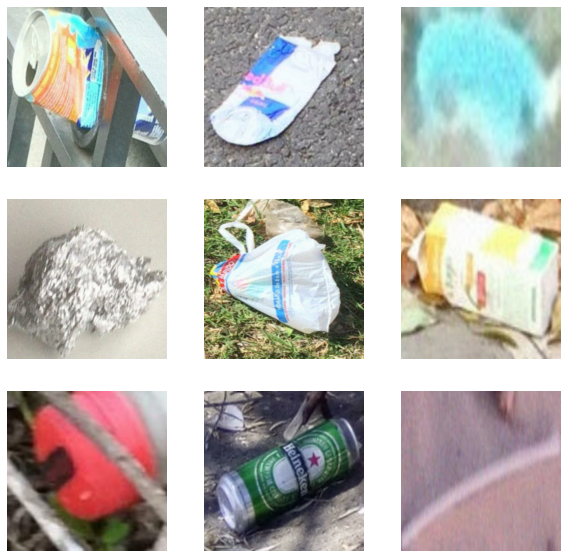

In [665]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

## Model

In [666]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization, SeparableConv2D

In [667]:
keras.backend.set_image_data_format('channels_last')

In [668]:
from tensorflow.keras.applications import Xception
input_shape = (img_size[0],img_size[0],3)
# Initialize the Pretrained Model
feature_extractor = Xception(weights='imagenet', 
                             input_shape=input_shape,
                             include_top=False)
feature_extractor.trainable = False

# Set the input layer
input_ = tf.keras.Input(shape=input_shape)

# Set the feature extractor layer
x = feature_extractor(input_, training=False)
# Set the pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(x)

# Set the final layer with sigmoid activation function
output_ = keras.layers.Dense(19, activation="softmax")(x)

# Create the new model object
model = tf.keras.Model(input_, output_)

In [669]:
Sequential([
    Conv2D(32, (3,3), padding='same', input_shape=(img_size[0],img_size[0],3), activation="relu"),
    Conv2D(32, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(64, (3,3), padding='same', activation="relu"),
    Conv2D(64, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(128, (3,3), padding='same', activation="relu"),
    Conv2D(128, (3,3), activation="relu"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(256, (3,3), padding='same', activation="relu"),
    Conv2D(256, (3,3), activation="relu"),
    MaxPool2D(pool_size=(2,2)),

    Conv2D(512, (3,3), padding='same', activation="relu"),
    Conv2D(512, (3,3), activation="relu"),
    
    Flatten(),
    Dense(256,activation="relu"),
    Dropout(0.2),
    Dense(19, activation="softmax")
])


model.summary() # To check our model!

Model: "model_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_131 (InputLayer)       [(None, 331, 331, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 11, 11, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d_33  (None, 2048)              0         
_________________________________________________________________
dense_113 (Dense)            (None, 19)                38931     
Total params: 20,900,411
Trainable params: 38,931
Non-trainable params: 20,861,480
_________________________________________________________________


In [670]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
            monitor = "val_accuracy",
            factor=np.sqrt(0.1),
            patience=3,
            min_lr=0.5e-6)

In [671]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='model.hdf5', verbose=1, save_best_only=True)

In [672]:
model.compile(
    optimizer="adam", 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [673]:
history = model.fit(train_ds,
               epochs=150,
               validation_data=val_ds,
               callbacks=[reduce_lr,checkpointer],
               class_weight=class_weight)

Epoch 1/150
26/26 [==============================] - 7s 186ms/step - loss: 29.7415 - accuracy: 0.0643 - val_loss: 16.0512 - val_accuracy: 0.1016

Epoch 00001: val_loss improved from inf to 16.05118, saving model to model.hdf5
Epoch 2/150
26/26 [==============================] - 5s 170ms/step - loss: 14.5718 - accuracy: 0.0922 - val_loss: 11.6286 - val_accuracy: 0.1016

Epoch 00002: val_loss improved from 16.05118 to 11.62864, saving model to model.hdf5
Epoch 3/150
26/26 [==============================] - 4s 167ms/step - loss: 9.5685 - accuracy: 0.1556 - val_loss: 9.1833 - val_accuracy: 0.1626

Epoch 00003: val_loss improved from 11.62864 to 9.18327, saving model to model.hdf5
Epoch 4/150
26/26 [==============================] - 5s 168ms/step - loss: 6.7192 - accuracy: 0.1845 - val_loss: 10.0074 - val_accuracy: 0.1260

Epoch 00004: val_loss did not improve from 9.18327
Epoch 5/150
26/26 [==============================] - 4s 168ms/step - loss: 5.3902 - accuracy: 0.2733 - val_loss: 10.079

KeyboardInterrupt: 

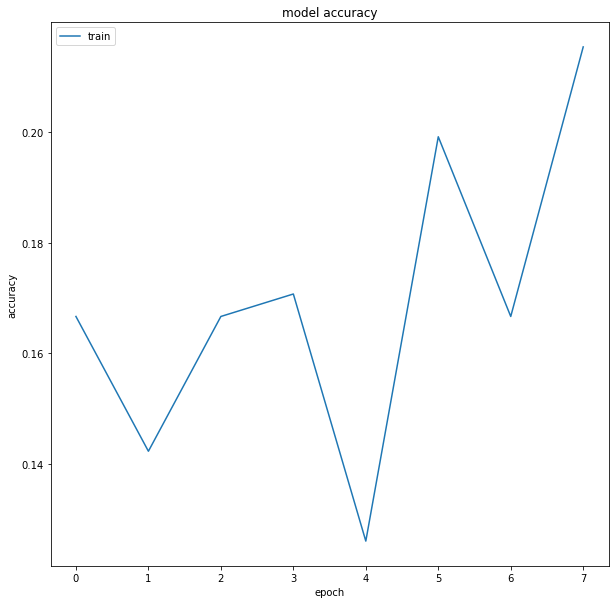

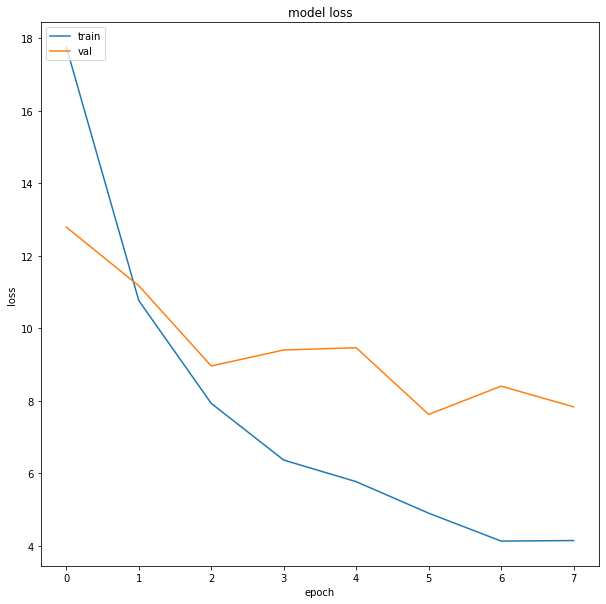

In [674]:
def plot_history(history):
    """
    Plot the loss & accuracy
    """
    plt.figure(figsize=[10,10])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.figure(figsize=[10,10])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

plot_history(history)

In [ ]:
def do_prediction():
    # prediction
    model.load_weights('model.hdf5')
    from random import randint
    name_img = os.listdir(os.path.join(path,'test'))[randint(0,387)]
    random_path_img = os.path.join(path,'test',name_img)
    image_array = cv2.imread(random_path_img, cv2.IMREAD_COLOR) # Loading the image
    image_array = cv2.resize(image_array, (img_size[0], img_size[0])) # Resize the image
    #image = cv2.imread(random_path_img)
    #cv2.imshow('image',image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    scores = model.predict(np.array([image_array]))
    classes = sorted(os.listdir(data))
    print(f'{name_img} -> {classes[scores.argmax(axis=-1)[0]]} {scores.max()}\n\n')
    for c,p in zip(classes,scores[0]):
        print(f'{c} prediction : {p}')





In [ ]:
def test_predictions():
    model.load_weights('model.hdf5')
    with open("test_predictions.csv","w") as file :
        images = []
        test_dir = os.listdir(os.path.join(path,'test'))
        file.write("index,path,pred\n")
        for img in test_dir:
            image_array = cv2.imread(os.path.join(path,'test',img), cv2.IMREAD_COLOR) # Loading the image
            images.append(cv2.resize(image_array, (img_size[0], img_size[0]))) # Resize the image
        scores = model.predict(np.array(images))
        for s,img in zip(scores.argmax(axis=-1),test_dir) :
            classe = classes[s]
            file.write(f"{img.split('.')[0]},train/{img},{classe}\n")

        
#test_predictions()